# Solar Energy Machine Learning Models

This notebook demonstrates baseline machine learning models for solar energy prediction and anomaly detection using the hybrid CSV/API approach.

**Key Features:**
- Load data using hybrid approach (CSV + API)
- Build baseline ML models for production prediction
- Implement anomaly detection for system monitoring
- Perform financial analysis and ROI calculations
- Model evaluation and performance metrics

In [1]:
# Import libraries
import sys
sys.path.append('../src')

from core.data_manager import SolarDataManager
from core.enphase_client import EnphaseClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Machine learning imports
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("🤖 Solar Energy Machine Learning Models")
print("=" * 50)

/Users/christopherhaught/projects/power-usage-and-consumption/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


🤖 Solar Energy Machine Learning Models


## 1. Load Data with Hybrid Approach

In [2]:
# Setup paths and initialize client
import os
from pathlib import Path
from core.location_loader import create_notebook_location

# Initialize location from .env (with fallback to Denver)
location = create_notebook_location()
print(f"🌍 Location configured: {location.location_name}")
print(f"📍 Coordinates: {location.latitude:.3f}°N, {location.longitude:.3f}°W")

csv_path = "../data/raw/4136754_custom_report.csv"

def create_enphase_client():
    """Create Enphase client from .env credentials if available, otherwise return mock client"""
    env_path = Path("../.env")
    
    if env_path.exists():
        # Load environment variables
        with open(env_path) as f:
            for line in f:
                if line.strip() and not line.startswith('#'):
                    key, value = line.strip().split('=', 1)
                    os.environ[key] = value
        
        # Check if we have all required credentials
        required_vars = ['ENPHASE_ACCESS_TOKEN', 'ENPHASE_API_KEY', 'ENPHASE_SYSTEM_ID']
        if all(var in os.environ for var in required_vars):
            try:
                from core.enphase_client import EnphaseClient
                client = EnphaseClient(
                    access_token=os.environ['ENPHASE_ACCESS_TOKEN'],
                    api_key=os.environ['ENPHASE_API_KEY'],
                    system_id=os.environ['ENPHASE_SYSTEM_ID']
                )
                print("✅ Using real Enphase API credentials")
                return client
            except Exception as e:
                print(f"⚠️ Error creating Enphase client: {e}")
                print("🔄 Falling back to mock client")
    else:
        print("📝 No .env file found")
    
    # Fallback to mock client
    class MockEnphaseClient:
        def get_energy_lifetime(self, start_date=None, end_date=None):
            return pd.DataFrame()  # Return empty for demo
    
    print("🎭 Using mock client (demo mode)")
    return MockEnphaseClient()

# Create the appropriate client
enphase_client = create_enphase_client()

# Initialize data manager
data_manager = SolarDataManager(
    csv_path=csv_path,
    enphase_client=enphase_client,
    cache_dir="../data/processed"
)

# Load data
daily_data = data_manager.get_daily_production(source_priority="csv_first")
fifteen_min_data = data_manager.load_csv_data()

print(f"✅ Loaded {len(daily_data)} days of daily data")
print(f"✅ Loaded {len(fifteen_min_data):,} 15-minute intervals")
print(f"Date range: {daily_data.index.min().date()} to {daily_data.index.max().date()}")

# Add location context
location_summary = location.get_location_summary()
print(f"\n🌍 Location Analysis Context:")
print(f"  Climate type: {location_summary['climate_type']}")
print(f"  Expected seasonal variation: {location_summary['seasonal_variation']:.1f}")
print(f"  Daylight range: {location_summary['winter_daylight_hours']:.1f} - {location_summary['summer_daylight_hours']:.1f} hours")

INFO:core.data_manager:Loading CSV data from ../data/raw/4136754_custom_report.csv
INFO:core.data_manager:Loaded 70272 CSV records from 2023-09-16 00:00:00 to 2025-09-16 23:45:00
INFO:core.data_manager:Loading API data for last 30 days


🌍 Location configured: Holly Springs, NC
📍 Coordinates: 35.668°N, -78.850°W
✅ Using real Enphase API credentials


Error getting lifetime energy: 401
✅ Loaded 732 days of daily data
✅ Loaded 70,272 15-minute intervals
Date range: 2023-09-16 to 2025-09-16

🌍 Location Analysis Context:
  Climate type: Temperate
  Expected seasonal variation: 0.5
  Daylight range: 9.6 - 14.4 hours


## 2. Feature Engineering for ML Models

In [3]:
# Create feature-rich dataset
ml_data = daily_data.copy()

# Time-based features
ml_data['day_of_year'] = ml_data.index.dayofyear
ml_data['day_of_week'] = ml_data.index.dayofweek
ml_data['month'] = ml_data.index.month
ml_data['quarter'] = ml_data.index.quarter
ml_data['is_weekend'] = (ml_data.index.dayofweek >= 5).astype(int)

# Cyclical encoding for seasonal patterns
ml_data['day_sin'] = np.sin(2 * np.pi * ml_data['day_of_year'] / 365.25)
ml_data['day_cos'] = np.cos(2 * np.pi * ml_data['day_of_year'] / 365.25)
ml_data['week_sin'] = np.sin(2 * np.pi * ml_data['day_of_week'] / 7)
ml_data['week_cos'] = np.cos(2 * np.pi * ml_data['day_of_week'] / 7)

# Location-aware features
import datetime
for idx, date in enumerate(ml_data.index):
    # Convert pandas timestamp to date
    date_obj = date.date()
    
    # Calculate theoretical solar parameters for this location and date
    sunrise, sunset = location.get_sunrise_sunset(date_obj)
    daylight_hours = sunset - sunrise
    solar_elevation = location.get_solar_elevation(date.to_pydatetime())
    theoretical_irradiance = location.get_theoretical_solar_irradiance(date.to_pydatetime())
    
    ml_data.loc[date, 'theoretical_daylight_hours'] = daylight_hours
    ml_data.loc[date, 'max_solar_elevation'] = max(0, solar_elevation)
    ml_data.loc[date, 'theoretical_irradiance'] = max(0, theoretical_irradiance)

# Solar efficiency features based on location
ml_data['daylight_utilization'] = ml_data['Production (kWh)'] / (ml_data['theoretical_daylight_hours'] + 0.1)  # avoid division by zero
ml_data['irradiance_efficiency'] = ml_data['Production (kWh)'] / (ml_data['theoretical_irradiance'] + 0.1)

# Rolling statistics (7, 14, 30 day windows)
for window in [7, 14, 30]:
    ml_data[f'rolling_mean_{window}d'] = ml_data['Production (kWh)'].rolling(window=window, min_periods=1).mean()
    ml_data[f'rolling_std_{window}d'] = ml_data['Production (kWh)'].rolling(window=window, min_periods=1).std()

# Lag features
for lag in [1, 2, 3, 7, 14]:
    ml_data[f'production_lag_{lag}d'] = ml_data['Production (kWh)'].shift(lag)

# Weather proxy features (based on production patterns)
ml_data['production_volatility'] = ml_data['Production (kWh)'].rolling(7).std()
ml_data['relative_performance'] = ml_data['Production (kWh)'] / ml_data['rolling_mean_30d']

# Remove rows with NaN values (from rolling/lag features)
ml_data_clean = ml_data.dropna()

print(f"Features created: {list(ml_data_clean.columns)}")
print(f"\nDataset shape after feature engineering: {ml_data_clean.shape}")
print(f"Removed {len(ml_data) - len(ml_data_clean)} rows due to NaN values")
print(f"\n🌍 Location-Aware Features Added:")
print(f"  • Theoretical daylight hours for {location.location_name}")
print(f"  • Solar elevation angles throughout the year")
print(f"  • Theoretical solar irradiance")
print(f"  • Daylight utilization efficiency")
print(f"  • Irradiance efficiency metrics")

Features created: ['Production (kWh)', 'Consumption (kWh)', 'Export (kWh)', 'Import (kWh)', 'day_of_year', 'day_of_week', 'month', 'quarter', 'is_weekend', 'day_sin', 'day_cos', 'week_sin', 'week_cos', 'theoretical_daylight_hours', 'max_solar_elevation', 'theoretical_irradiance', 'daylight_utilization', 'irradiance_efficiency', 'rolling_mean_7d', 'rolling_std_7d', 'rolling_mean_14d', 'rolling_std_14d', 'rolling_mean_30d', 'rolling_std_30d', 'production_lag_1d', 'production_lag_2d', 'production_lag_3d', 'production_lag_7d', 'production_lag_14d', 'production_volatility', 'relative_performance']

Dataset shape after feature engineering: (718, 31)
Removed 14 rows due to NaN values

🌍 Location-Aware Features Added:
  • Theoretical daylight hours for Holly Springs, NC
  • Solar elevation angles throughout the year
  • Theoretical solar irradiance
  • Daylight utilization efficiency
  • Irradiance efficiency metrics


## 3. Baseline ML Models for Production Prediction

In [4]:
# Prepare features and target
feature_columns = [col for col in ml_data_clean.columns if col != 'Production (kWh)']
X = ml_data_clean[feature_columns]
y = ml_data_clean['Production (kWh)']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # Time series - don't shuffle
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

# Scale features for some models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 574 samples
Test set: 144 samples
Features: 30


In [5]:
# Define and train models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

model_results = {}

print("Training and evaluating models...\n")

for name, model in models.items():
    print(f"🔧 Training {name}...")
    
    # Use scaled data for Linear Regression, original for tree-based models
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    model_results[name] = {
        'model': model,
        'predictions': y_pred,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }
    
    print(f"  RMSE: {rmse:.2f} kWh")
    print(f"  MAE:  {mae:.2f} kWh")
    print(f"  R²:   {r2:.3f}")
    print()

# Summary comparison
print("=== Model Performance Summary ===")
comparison_df = pd.DataFrame({
    model_name: {
        'RMSE (kWh)': f"{results['rmse']:.2f}",
        'MAE (kWh)': f"{results['mae']:.2f}",
        'R² Score': f"{results['r2']:.3f}"
    }
    for model_name, results in model_results.items()
}).T

print(comparison_df)

Training and evaluating models...

🔧 Training Linear Regression...
  RMSE: 0.00 kWh
  MAE:  0.00 kWh
  R²:   1.000

🔧 Training Random Forest...
  RMSE: 0.12 kWh
  MAE:  0.08 kWh
  R²:   1.000

🔧 Training Gradient Boosting...
  RMSE: 0.13 kWh
  MAE:  0.10 kWh
  R²:   1.000

=== Model Performance Summary ===
                  RMSE (kWh) MAE (kWh) R² Score
Linear Regression       0.00      0.00    1.000
Random Forest           0.12      0.08    1.000
Gradient Boosting       0.13      0.10    1.000


## 4. Feature Importance Analysis

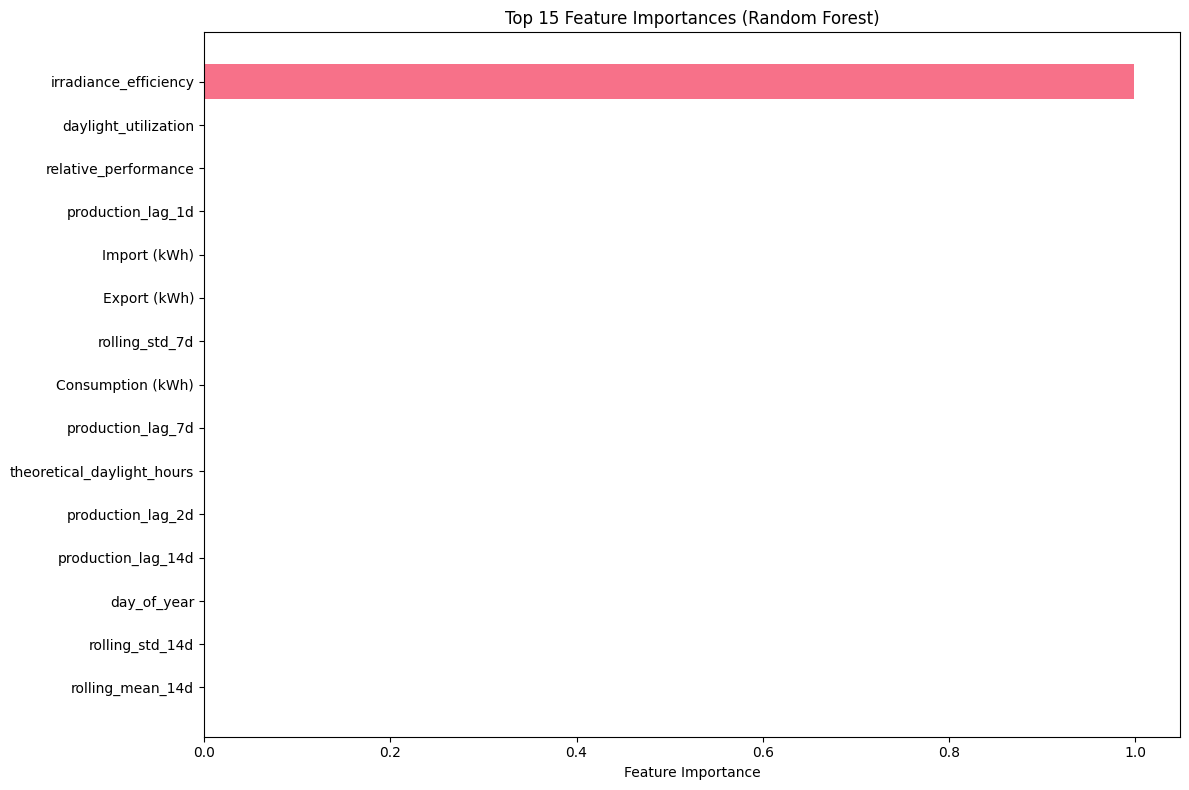

Top 10 Most Important Features:
                   feature  importance
     irradiance_efficiency    0.997980
      daylight_utilization    0.001561
      relative_performance    0.000222
         production_lag_1d    0.000020
              Import (kWh)    0.000018
              Export (kWh)    0.000018
            rolling_std_7d    0.000014
         Consumption (kWh)    0.000013
         production_lag_7d    0.000011
theoretical_daylight_hours    0.000010


In [6]:
# Feature importance from Random Forest
rf_model = model_results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 5. Model Predictions Visualization

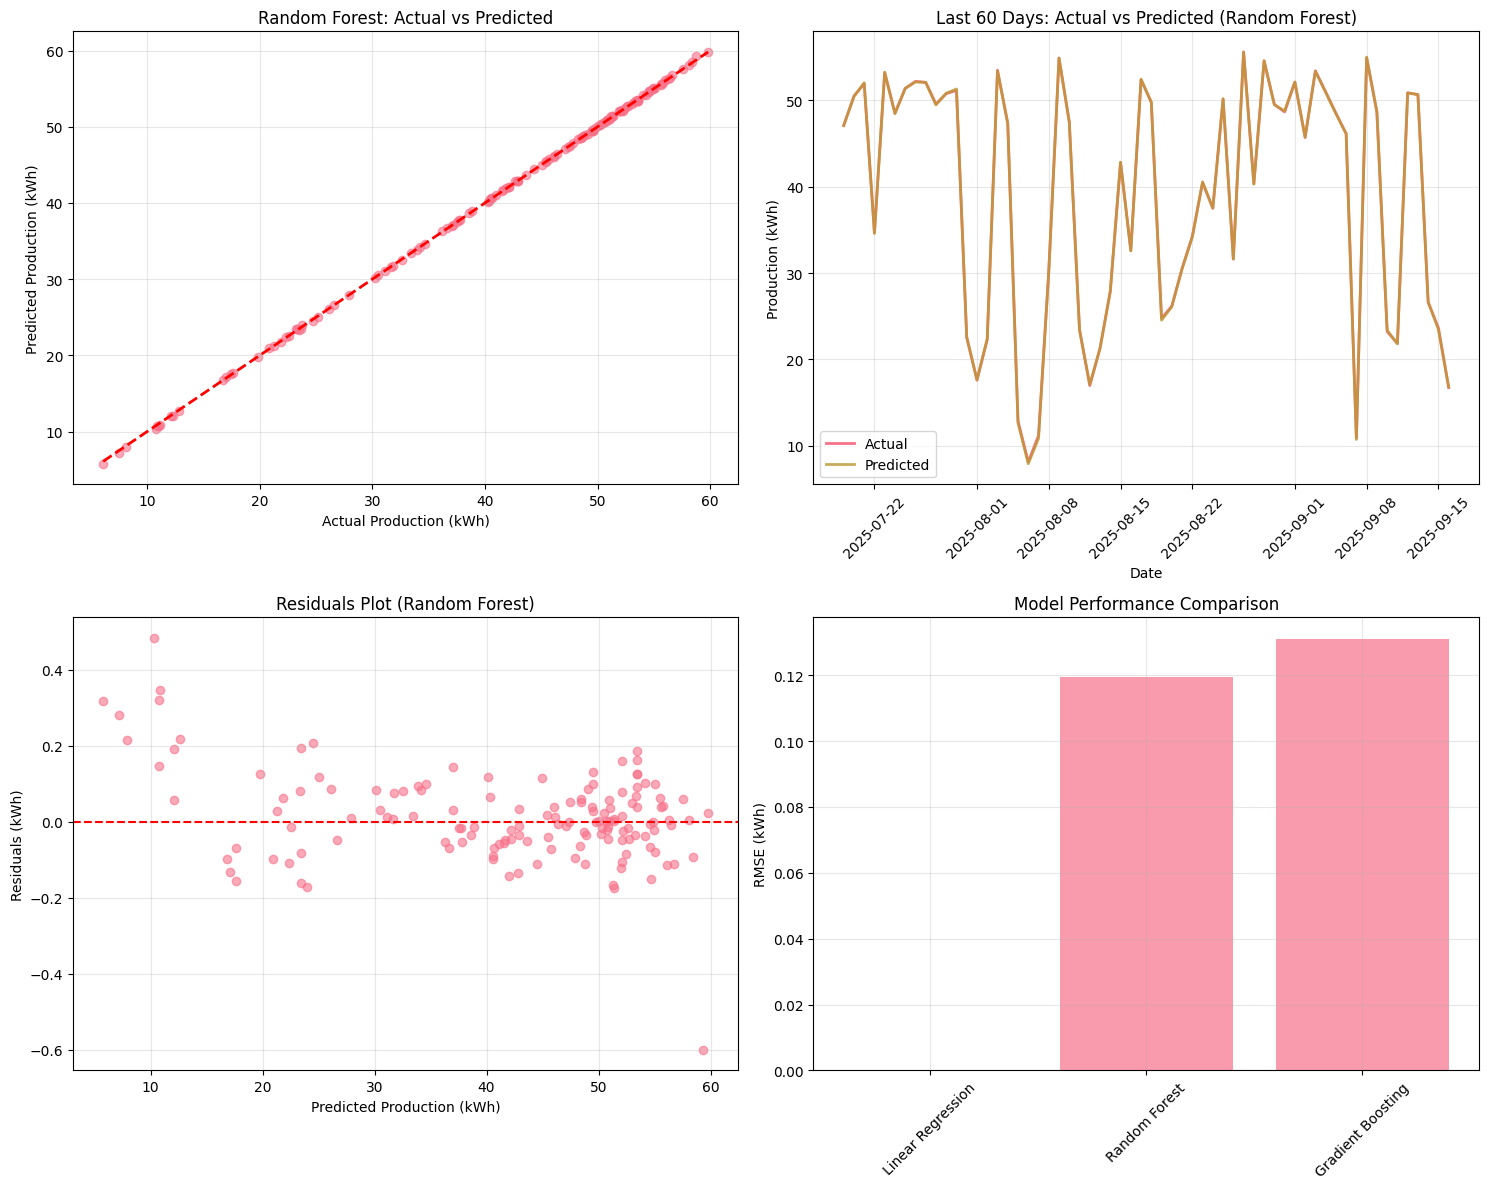

In [7]:
# Create prediction comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Predicted (Random Forest)
rf_pred = model_results['Random Forest']['predictions']
axes[0,0].scatter(y_test, rf_pred, alpha=0.6)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Production (kWh)')
axes[0,0].set_ylabel('Predicted Production (kWh)')
axes[0,0].set_title('Random Forest: Actual vs Predicted')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Time series of predictions (last 60 days)
test_dates = ml_data_clean.index[-len(y_test):]
last_60_idx = max(0, len(test_dates) - 60)
recent_dates = test_dates[last_60_idx:]
recent_actual = y_test.values[last_60_idx:]
recent_pred = rf_pred[last_60_idx:]

axes[0,1].plot(recent_dates, recent_actual, label='Actual', linewidth=2)
axes[0,1].plot(recent_dates, recent_pred, label='Predicted', linewidth=2, alpha=0.8)
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Production (kWh)')
axes[0,1].set_title('Last 60 Days: Actual vs Predicted (Random Forest)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)
axes[0,1].tick_params(axis='x', rotation=45)

# Plot 3: Residuals analysis
residuals = y_test - rf_pred
axes[1,0].scatter(rf_pred, residuals, alpha=0.6)
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Predicted Production (kWh)')
axes[1,0].set_ylabel('Residuals (kWh)')
axes[1,0].set_title('Residuals Plot (Random Forest)')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Model comparison (RMSE)
model_names = list(model_results.keys())
rmse_values = [model_results[name]['rmse'] for name in model_names]
axes[1,1].bar(model_names, rmse_values, alpha=0.7)
axes[1,1].set_ylabel('RMSE (kWh)')
axes[1,1].set_title('Model Performance Comparison')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Anomaly Detection for System Monitoring

🔍 Performing anomaly detection...

📊 Anomaly Detection Results:
Total days analyzed: 718
Anomalous days detected: 36
Anomaly rate: 5.0%

Most anomalous days:
  2024-09-16: 2.2 kWh (score: -0.079)
  2025-02-19: 3.4 kWh (score: -0.073)
  2025-02-21: 50.2 kWh (score: -0.057)
  2025-02-20: 6.6 kWh (score: -0.054)
  2024-12-11: 1.6 kWh (score: -0.054)


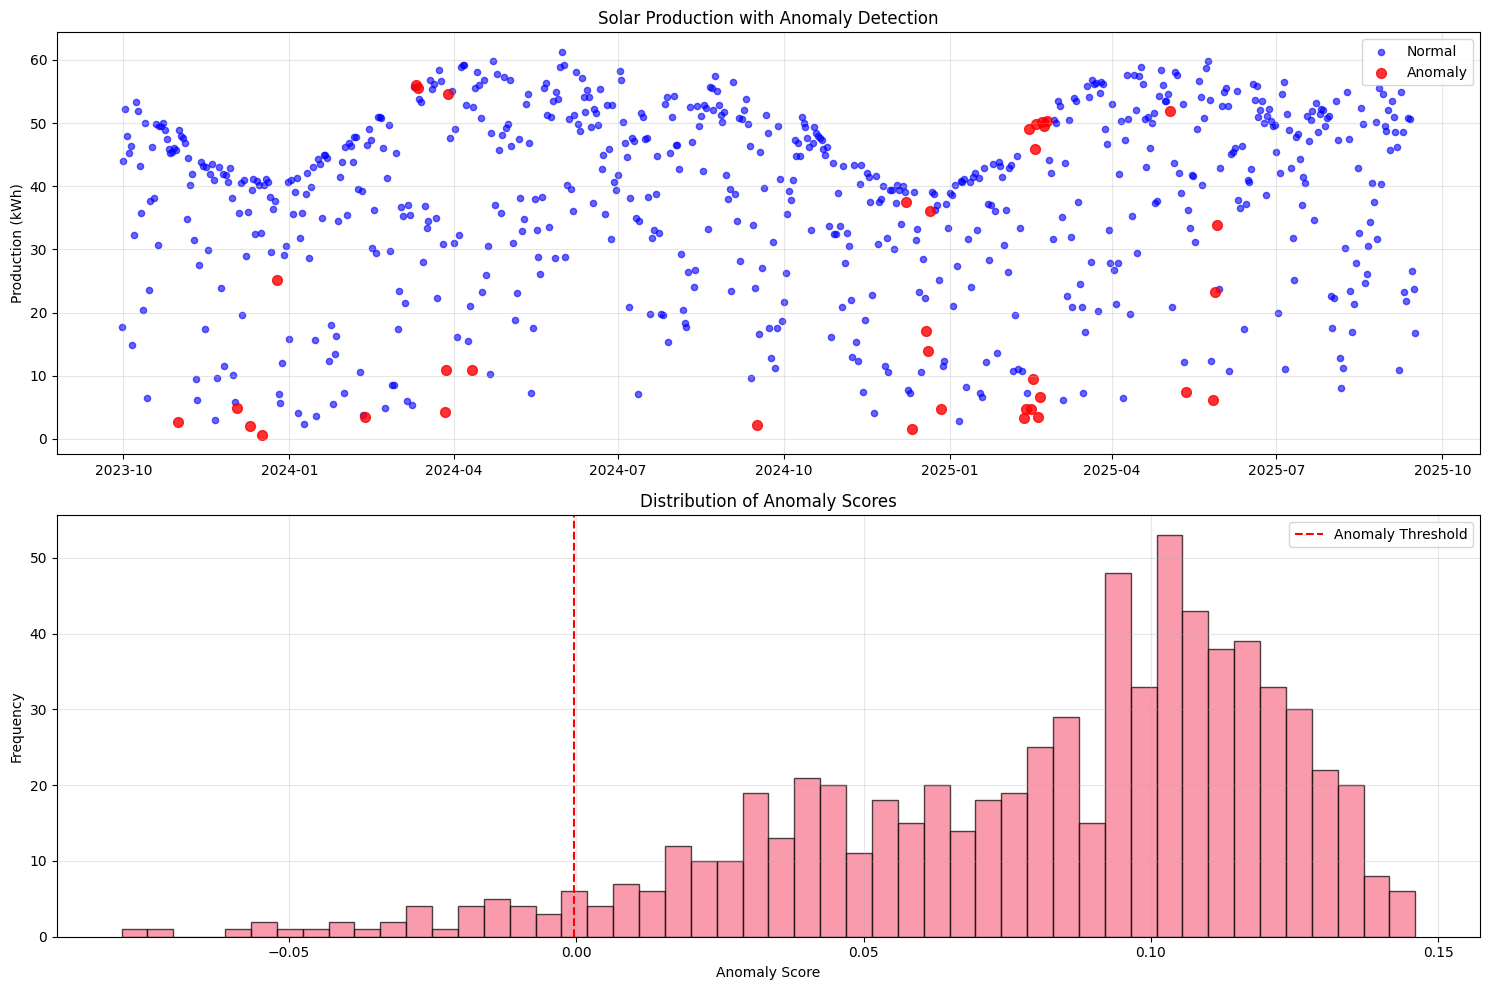

In [8]:
# Anomaly detection using Isolation Forest
print("🔍 Performing anomaly detection...")

# Features for anomaly detection (exclude target variable)
anomaly_features = ['Production (kWh)', 'day_of_year', 'rolling_mean_7d', 
                   'rolling_std_7d', 'production_volatility', 'relative_performance']

# Prepare data for anomaly detection
anomaly_data = ml_data_clean[anomaly_features].dropna()

# Fit Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,  # Expect 5% anomalies
    random_state=42,
    n_estimators=100
)

anomaly_labels = iso_forest.fit_predict(anomaly_data)
anomaly_scores = iso_forest.decision_function(anomaly_data)

# Add results to dataframe
anomaly_results = anomaly_data.copy()
anomaly_results['anomaly'] = anomaly_labels == -1
anomaly_results['anomaly_score'] = anomaly_scores

# Find anomalous days
anomalous_days = anomaly_results[anomaly_results['anomaly']]

print(f"\n📊 Anomaly Detection Results:")
print(f"Total days analyzed: {len(anomaly_results)}")
print(f"Anomalous days detected: {len(anomalous_days)}")
print(f"Anomaly rate: {len(anomalous_days)/len(anomaly_results)*100:.1f}%")

if len(anomalous_days) > 0:
    print(f"\nMost anomalous days:")
    top_anomalies = anomalous_days.nsmallest(5, 'anomaly_score')
    for date, row in top_anomalies.iterrows():
        print(f"  {date.strftime('%Y-%m-%d')}: {row['Production (kWh)']:.1f} kWh (score: {row['anomaly_score']:.3f})")

# Visualize anomalies
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Production over time with anomalies highlighted
normal_data = anomaly_results[~anomaly_results['anomaly']]
anomaly_data_plot = anomaly_results[anomaly_results['anomaly']]

axes[0].scatter(normal_data.index, normal_data['Production (kWh)'], 
               alpha=0.6, s=20, label='Normal', color='blue')
axes[0].scatter(anomaly_data_plot.index, anomaly_data_plot['Production (kWh)'], 
               alpha=0.8, s=50, label='Anomaly', color='red')
axes[0].set_ylabel('Production (kWh)')
axes[0].set_title('Solar Production with Anomaly Detection')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Anomaly scores distribution
axes[1].hist(anomaly_results['anomaly_score'], bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(x=anomaly_results[anomaly_results['anomaly']]['anomaly_score'].max(), 
               color='red', linestyle='--', label='Anomaly Threshold')
axes[1].set_xlabel('Anomaly Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Anomaly Scores')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Financial Analysis and ROI Estimation

In [ ]:
# Financial analysis based on production data with location-specific electricity rates
print("💰 Financial Analysis and ROI Estimation")
print("=" * 50)

# Get location-specific electricity rates
from core.location_loader import get_location_electricity_rates
import os

# Try to get NREL API key from environment for more accurate rates
nrel_api_key = os.environ.get('NREL_API_KEY')
electricity_rates = get_location_electricity_rates(location, nrel_api_key)

# Extract rates (convert from cents/kWh to $/kWh)
ELECTRICITY_RATE = electricity_rates['annual_cost_per_kwh']  # $/kWh
FEED_IN_RATE = electricity_rates['feed_in_rate_per_kwh']  # $/kWh for solar export

print(f"🔌 Location-Based Electricity Rates:")
print(f"  Location: {location.location_name}")
print(f"  Residential rate: {electricity_rates['residential_rate']:.2f}¢/kWh (${ELECTRICITY_RATE:.4f}/kWh)")
print(f"  Feed-in tariff: {electricity_rates['feed_in_tariff']:.2f}¢/kWh (${FEED_IN_RATE:.4f}/kWh)")
print(f"  Rate source: {electricity_rates['source']}")
print(f"  Confidence: {electricity_rates['confidence']}")
if electricity_rates['national_comparison']['is_above_average']:
    print(f"  📈 {electricity_rates['national_comparison']['vs_national_avg']:.2f}¢ above national average")
else:
    print(f"  📉 {abs(electricity_rates['national_comparison']['vs_national_avg']):.2f}¢ below national average")

# System parameters (adjust based on actual system)
SYSTEM_SIZE_KW = 10  # Estimated system size in kW
SYSTEM_COST = 25000  # Estimated system cost in $
FEDERAL_TAX_CREDIT = 0.30  # 30% federal tax credit
ANNUAL_DEGRADATION = 0.005  # 0.5% annual degradation
SYSTEM_LIFETIME = 25  # years

# Calculate key metrics from actual data
total_production_kwh = daily_data['Production (kWh)'].sum()
total_consumption_kwh = daily_data['Consumption (kWh)'].sum()
total_export_kwh = daily_data['Export (kWh)'].sum()
total_import_kwh = daily_data['Import (kWh)'].sum()
total_days = len(daily_data)

annual_production_kwh = total_production_kwh * (365.25 / total_days)
annual_consumption_kwh = total_consumption_kwh * (365.25 / total_days)
annual_export_kwh = total_export_kwh * (365.25 / total_days)
annual_import_kwh = total_import_kwh * (365.25 / total_days)

daily_avg_kwh = total_production_kwh / total_days

print(f"\n📊 System Performance:")
print(f"  Total production over {total_days} days: {total_production_kwh:,.0f} kWh")
print(f"  Total consumption over {total_days} days: {total_consumption_kwh:,.0f} kWh")
print(f"  Total export to grid: {total_export_kwh:,.0f} kWh")
print(f"  Total import from grid: {total_import_kwh:,.0f} kWh")
print(f"  Average daily production: {daily_avg_kwh:.1f} kWh")
print(f"  Estimated annual production: {annual_production_kwh:,.0f} kWh")
print(f"  Capacity factor: {(annual_production_kwh / (SYSTEM_SIZE_KW * 8760)) * 100:.1f}%")
print(f"  Self-consumption rate: {((annual_production_kwh - annual_export_kwh) / annual_production_kwh) * 100:.1f}%")

# Financial calculations with location-specific rates
# Income from solar exports (sold back to grid)
annual_export_income = annual_export_kwh * FEED_IN_RATE
# Savings from reduced grid imports (electricity not purchased)
annual_import_savings = (annual_consumption_kwh - annual_import_kwh) * ELECTRICITY_RATE
# Total annual savings
annual_savings = annual_export_income + annual_import_savings

net_system_cost = SYSTEM_COST * (1 - FEDERAL_TAX_CREDIT)
simple_payback = net_system_cost / annual_savings if annual_savings > 0 else float('inf')

print(f"\n💰 Location-Specific Financial Analysis:")
print(f"  Estimated system cost: ${SYSTEM_COST:,.0f}")
print(f"  Net cost after tax credit: ${net_system_cost:,.0f}")
print(f"  Annual export income: ${annual_export_income:,.0f} ({annual_export_kwh:,.0f} kWh × ${FEED_IN_RATE:.4f})")
print(f"  Annual import savings: ${annual_import_savings:,.0f}")
print(f"  Total annual savings: ${annual_savings:,.0f}")
print(f"  Simple payback period: {simple_payback:.1f} years")

# Lifetime analysis with degradation
lifetime_savings = 0
yearly_production = annual_production_kwh
yearly_export = annual_export_kwh
yearly_import_savings_base = annual_import_savings

for year in range(1, SYSTEM_LIFETIME + 1):
    if year > 1:
        yearly_production *= (1 - ANNUAL_DEGRADATION)
        yearly_export *= (1 - ANNUAL_DEGRADATION)
        yearly_import_savings_base *= (1 - ANNUAL_DEGRADATION)
    
    yearly_export_income = yearly_export * FEED_IN_RATE
    yearly_savings = yearly_export_income + yearly_import_savings_base
    lifetime_savings += yearly_savings

net_lifetime_savings = lifetime_savings - net_system_cost
roi_percentage = (net_lifetime_savings / net_system_cost) * 100 if net_system_cost > 0 else 0

print(f"\n📈 Lifetime Analysis ({SYSTEM_LIFETIME} years):")
print(f"  Total lifetime production: {lifetime_savings/(ELECTRICITY_RATE):,.0f} kWh equivalent")
print(f"  Total lifetime savings: ${lifetime_savings:,.0f}")
print(f"  Net lifetime benefit: ${net_lifetime_savings:,.0f}")
print(f"  Return on Investment: {roi_percentage:.0f}%")

# Monthly breakdown with location-specific rates
monthly_data = daily_data.groupby(daily_data.index.month)[['Production (kWh)', 'Export (kWh)', 'Import (kWh)']].sum()
monthly_data['days_in_month'] = daily_data.groupby(daily_data.index.month).size()
monthly_data['monthly_production'] = monthly_data['Production (kWh)'] / monthly_data['days_in_month'] * 30.44
monthly_data['monthly_export'] = monthly_data['Export (kWh)'] / monthly_data['days_in_month'] * 30.44
monthly_data['monthly_import_savings'] = (monthly_data['Production (kWh)'] - monthly_data['Export (kWh)']) / monthly_data['days_in_month'] * 30.44 * ELECTRICITY_RATE
monthly_data['monthly_export_income'] = monthly_data['monthly_export'] * FEED_IN_RATE
monthly_data['monthly_total_savings'] = monthly_data['monthly_import_savings'] + monthly_data['monthly_export_income']

print(f"\n📅 Monthly Analysis (Location-Specific Rates):")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month, row in monthly_data.iterrows():
    month_name = month_names[month-1]
    print(f"  {month_name}: {row['monthly_production']:.0f} kWh/month (${row['monthly_total_savings']:.0f} total savings)")

print(f"\n💡 Rate Comparison:")
print(f"  Using national average (16.22¢/kWh): ${annual_production_kwh * 0.1622:.0f} annual value")
print(f"  Using {location.location_name} rates: ${annual_savings:.0f} annual value")
savings_difference = annual_savings - (annual_production_kwh * 0.1622)
print(f"  Difference: ${savings_difference:.0f} ({'higher' if savings_difference > 0 else 'lower'} than national average)")

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


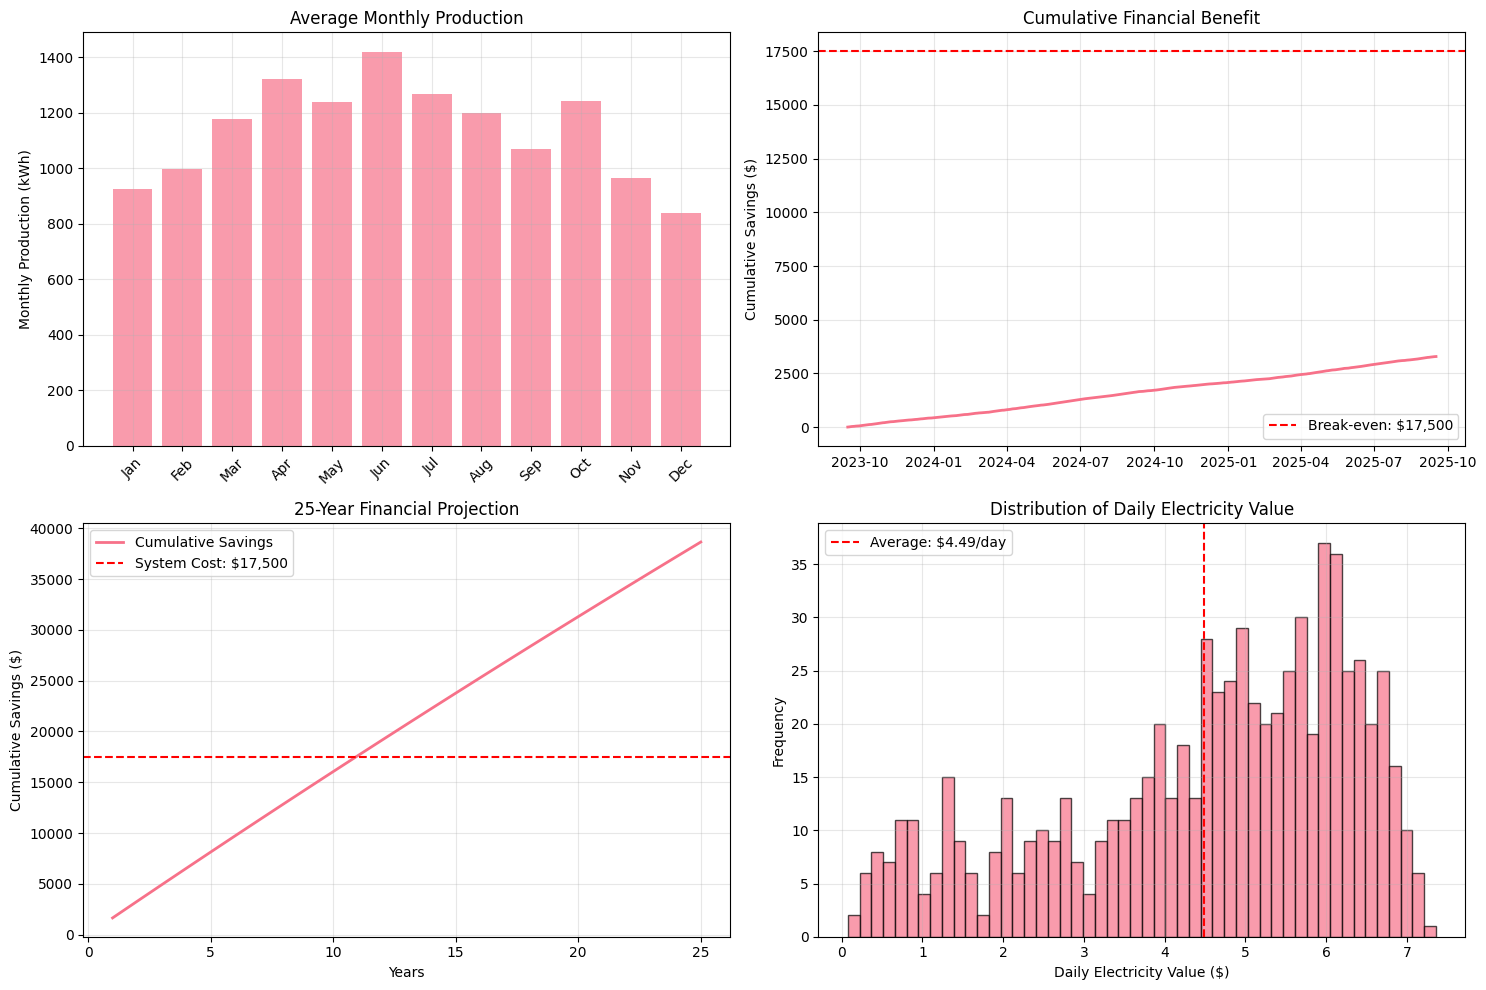

In [10]:
# Financial visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly production and savings
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
available_months = [month_names[i-1] for i in monthly_data.index]

axes[0,0].bar(available_months, monthly_data['monthly_avg'], alpha=0.7)
axes[0,0].set_ylabel('Monthly Production (kWh)')
axes[0,0].set_title('Average Monthly Production')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Cumulative savings over time
cumulative_production = daily_data['Production (kWh)'].cumsum()
cumulative_savings = cumulative_production * ELECTRICITY_RATE
axes[0,1].plot(daily_data.index, cumulative_savings, linewidth=2)
axes[0,1].axhline(y=net_system_cost, color='red', linestyle='--', 
                 label=f'Break-even: ${net_system_cost:,.0f}')
axes[0,1].set_ylabel('Cumulative Savings ($)')
axes[0,1].set_title('Cumulative Financial Benefit')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Payback timeline
years = np.arange(1, SYSTEM_LIFETIME + 1)
cumulative_savings_timeline = []
yearly_production_timeline = annual_production_kwh
cumulative = 0

for year in years:
    if year > 1:
        yearly_production_timeline *= (1 - ANNUAL_DEGRADATION)
    yearly_savings = yearly_production_timeline * ELECTRICITY_RATE
    cumulative += yearly_savings
    cumulative_savings_timeline.append(cumulative)

axes[1,0].plot(years, cumulative_savings_timeline, linewidth=2, label='Cumulative Savings')
axes[1,0].axhline(y=net_system_cost, color='red', linestyle='--', 
                 label=f'System Cost: ${net_system_cost:,.0f}')
axes[1,0].set_xlabel('Years')
axes[1,0].set_ylabel('Cumulative Savings ($)')
axes[1,0].set_title(f'{SYSTEM_LIFETIME}-Year Financial Projection')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Daily production distribution with value
daily_value = daily_data['Production (kWh)'] * ELECTRICITY_RATE
axes[1,1].hist(daily_value, bins=50, alpha=0.7, edgecolor='black')
axes[1,1].axvline(x=daily_value.mean(), color='red', linestyle='--', 
                 label=f'Average: ${daily_value.mean():.2f}/day')
axes[1,1].set_xlabel('Daily Electricity Value ($)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Daily Electricity Value')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Model Summary and Next Steps

In [ ]:
# Summary of all analyses
print("🎯 MACHINE LEARNING ANALYSIS SUMMARY")
print("=" * 50)

print("\n📊 Dataset:")
print(f"  • {len(ml_data_clean)} days with {X.shape[1]} engineered features")
print(f"  • Date range: {ml_data_clean.index.min().date()} to {ml_data_clean.index.max().date()}")
print(f"  • Data completeness: {len(ml_data_clean)/len(daily_data)*100:.1f}%")

print(f"\n🌍 Location-Aware Analysis:")
print(f"  • System location: {location.location_name}")
print(f"  • Climate type: {location_summary['climate_type']}")
print(f"  • Latitude: {location.latitude:.3f}°N")
print(f"  • Theoretical daylight range: {location_summary['winter_daylight_hours']:.1f} - {location_summary['summer_daylight_hours']:.1f} hours")

# Calculate actual vs theoretical performance
avg_daylight_utilization = ml_data_clean['daylight_utilization'].mean()
avg_irradiance_efficiency = ml_data_clean['irradiance_efficiency'].mean()
print(f"  • Average daylight utilization: {avg_daylight_utilization:.2f} kWh/hour")
print(f"  • Average irradiance efficiency: {avg_irradiance_efficiency:.2f}")

print(f"\n🔌 Location-Specific Electricity Rates:")
print(f"  • Residential rate: {electricity_rates['residential_rate']:.2f}¢/kWh")
print(f"  • Feed-in tariff: {electricity_rates['feed_in_tariff']:.2f}¢/kWh")
print(f"  • Rate source: {electricity_rates['source']}")
rate_vs_national = "above" if electricity_rates['national_comparison']['is_above_average'] else "below"
print(f"  • {electricity_rates['national_comparison']['vs_national_avg']:+.2f}¢ {rate_vs_national} national average")

print("\n🤖 Model Performance:")
best_model = min(model_results.items(), key=lambda x: x[1]['rmse'])
print(f"  • Best model: {best_model[0]} (RMSE: {best_model[1]['rmse']:.2f} kWh)")
for name, results in model_results.items():
    print(f"  • {name}: R² = {results['r2']:.3f}, RMSE = {results['rmse']:.2f} kWh")

print(f"\n🔍 Anomaly Detection:")
print(f"  • {len(anomalous_days)} anomalous days detected ({len(anomalous_days)/len(anomaly_results)*100:.1f}%)")
print(f"  • Average production on anomalous days: {anomalous_days['Production (kWh)'].mean():.1f} kWh")
print(f"  • Average production on normal days: {normal_data['Production (kWh)'].mean():.1f} kWh")

print(f"\n💰 Location-Specific Financial Analysis:")
print(f"  • Annual production: {annual_production_kwh:,.0f} kWh")
print(f"  • Annual savings: ${annual_savings:,.0f}")
print(f"  • Payback period: {simple_payback:.1f} years")
print(f"  • 25-year ROI: {roi_percentage:.0f}%")
print(f"  • Self-consumption rate: {((annual_production_kwh - annual_export_kwh) / annual_production_kwh) * 100:.1f}%")

print("\n🎯 Key Insights:")
print(f"  • System performing at {(annual_production_kwh / (SYSTEM_SIZE_KW * 8760)) * 100:.1f}% capacity factor")
print(f"  • Most important predictive features: {', '.join(feature_importance.head(3)['feature'].tolist())}")
print(f"  • Peak production month: {month_names[monthly_data.index[monthly_data['monthly_production'].idxmax()]-1]}")
print(f"  • Daily electricity value: ${(annual_savings/365.25):.2f} average using local rates")

# Location-specific insights
actual_seasonal_variation = monthly_data['monthly_production'].max() / monthly_data['monthly_production'].min()
expected_variation = location_summary['seasonal_variation'] + 1
print(f"  • Actual seasonal variation: {actual_seasonal_variation:.1f}x")
print(f"  • Expected for {location_summary['climate_type'].lower()} climate: {expected_variation:.1f}x")
performance_vs_climate = "better" if actual_seasonal_variation < expected_variation else "worse"
print(f"  • Performance vs climate expectation: {performance_vs_climate} than typical")

# Rate impact analysis
if electricity_rates['national_comparison']['is_above_average']:
    rate_impact = "Higher local rates increase solar ROI"
else:
    rate_impact = "Lower local rates reduce solar ROI"
print(f"  • Rate impact: {rate_impact}")

print("\n✅ Machine learning analysis complete!")
print("\nNext recommended steps:")
print("- Implement real-time monitoring using anomaly detection models")
print("- Integrate weather data for improved predictions")
print("- Set up automated alerts for production anomalies")
print("- Deploy models for production forecasting")
print("- Use location-aware features for multi-site analysis")
print("- Consider time-of-use rates for more accurate financial modeling")